In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re, pickle, multiprocessing, time
from collections import defaultdict
from collections import Counter
import itertools 
import subprocess
%matplotlib inline
from pydeseq2.dds import DeseqDataSet
from pydeseq2.dds import DefaultInference
from pydeseq2.ds import DeseqStats
inference = DefaultInference(n_cpus=20)
from collections import Counter
from scipy.stats import fisher_exact
from scipy.optimize import curve_fit
from scipy import special as sp
from scipy.integrate import quad
from scipy.optimize import minimize 
from scipy.stats import pearsonr
from scipy.stats import fisher_exact
import math

/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Processing of K562 Screen, can be skipped

In [20]:
sample = ['ABL_Plasmid_1', 'ABL_Plasmid_2', 'K562_ABE_1', 'K562_ABE_2']

for file in sample:
        subprocess.call(['cutadapt', '-g', 'TGGAAAGGACGAAACACC...GTTTTAGAGCTAGAAAT', '-j', '20', '-m', '17', '-M', '23',
                     file + '.fq.gz', '-o', file + ".fq"])

This is cutadapt 3.5 with Python 3.10.12
Command line parameters: -g TGGAAAGGACGAAACACC...GTTTTAGAGCTAGAAAT -j 20 -m 17 -M 23 ABL_Plasmid_1.fq.gz -o ABL_Plasmid_1.fq
Processing reads on 20 cores in single-end mode ...
Finished in 21.90 s (2 µs/read; 33.40 M reads/minute).

=== Summary ===

Total reads processed:              12,189,279
Reads with adapters:                11,789,476 (96.7%)

== Read fate breakdown ==
Reads that were too short:             615,923 (5.1%)
Reads that were too long:              418,696 (3.4%)
Reads written (passing filters):    11,154,660 (91.5%)

Total basepairs processed: 1,828,391,850 bp
Total written (filtered):    228,276,339 bp (12.5%)

=== Adapter 3 ===

Sequence: TGGAAAGGACGAAACACC...GTTTTAGAGCTAGAAAT; Type: linked; Length: 18+17; 5' trimmed: 11789476 times; 3' trimmed: 11789476 times

Minimum overlap: 3+3
No. of allowed errors:
1-9 bp: 0; 10-18 bp: 1

No. of allowed errors:
1-9 bp: 0; 10-17 bp: 1

Overview of removed sequences at 5' end
length	cou

In [197]:
for d in sample:
    subprocess.call(['bowtie', '-n', '2', '-p', '20', '-q', '--norc', '--best', '-l', '17','-x', 'BCR_ABL_Control_sgRNA', d + '.fq', d + '.txt'])

# reads processed: 11154660
# reads with at least one alignment: 9364523 (83.95%)
# reads that failed to align: 1790137 (16.05%)
Reported 9364523 alignments
# reads processed: 14969499
# reads with at least one alignment: 12554447 (83.87%)
# reads that failed to align: 2415052 (16.13%)
Reported 12554447 alignments
# reads processed: 7320977
# reads with at least one alignment: 6242323 (85.27%)
# reads that failed to align: 1078654 (14.73%)
Reported 6242323 alignments
# reads processed: 6733816
# reads with at least one alignment: 5741669 (85.27%)
# reads that failed to align: 992147 (14.73%)
Reported 5741669 alignments


In [21]:
sgNames_fasta = open("gBCRABL_Control_sgRNA.fasta", "r").read().splitlines()[::2]
sgNames = [sg[1:] for sg in sgNames_fasta]
ScreenDF = pd.DataFrame(sgNames, columns=['sgName'])
ScreenDF.head()

,sgName
0,BCRABL_3149
1,BCRABL_332
2,BCRABL_467
3,BCRABL_691
4,BCRABL_335


In [22]:
#GET COUNTS FROM ALIGNMENT WITHOUT CHEKING ERRORS
for d in sample:
    Bowtie_output = open((d+".txt"), "r").read().split('\t')
    sgRNA_IDs = Bowtie_output[2::7] #sgRNA ID list
    sg_Frequency = Counter(sgRNA_IDs)
    sgCounts = []
    for sgN in sgNames:
        sgCounts.append(sg_Frequency[sgN])
    ScreenDF[d] = sgCounts
    print([d, len(sgRNA_IDs)])

['ABL_Plasmid_1', 9364523]
['ABL_Plasmid_2', 12554447]
['K562_ABE_1', 6242323]
['K562_ABE_2', 5741669]


In [31]:
ScreenDF.to_csv('K562 ABE Screen Counts.csv')

Comparing K562 and Ba/F3 BCR-ABL Screens

In [2]:
OLD_meta = pd.DataFrame([['ABL_Plasmid_1', 'plasmid'],
                         ['ABL_Plasmid_2', 'plasmid'],
                         ['K562_ABE_1', 'K562'],
                         ['K562_ABE_2', 'K562']],
                        columns = ['Samples', 'Condition'])
OLD_meta = OLD_meta.set_index('Samples')
OLD_count = pd.read_csv('K562 ABE Screen Counts.csv', usecols =['sgName'] + OLD_meta.index.tolist())
OLD_count = OLD_count.set_index('sgName')
OLD_count = OLD_count.iloc[:3154] #remove control sgRNA

NEW_meta = pd.read_csv('NEW_Screen_Condition_Matrix.csv')
NEW_meta = NEW_meta.set_index('Samples')
NEW_meta['Condition'] = NEW_meta['Condition'].str.replace('_', '-')
NEW_count = pd.read_csv('NEW_BCRABL_Screen_Counts.csv', usecols = ['sgName'] + NEW_meta.index.tolist())
NEW_count.loc[~(NEW_count['sgName']=='BCRABL_2592')] #drop contaminating outlier
NEW_count = NEW_count.set_index('sgName')

guide_predictions = pd.read_csv('BCRABBL NG sgRNA Predicted Mutagenesis Classed Labeled with Final Class 20240130 2to12.csv')

In [3]:
dds_old = DeseqDataSet(
    counts=OLD_count.T,
    metadata=OLD_meta,
    design_factors="Condition",
    refit_cooks=True,
    n_cpus=20)
dds_old.deseq2()

Fitting size factors...
... done in 0.00 seconds.

/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a s

In [4]:
dds_new = DeseqDataSet(
    counts=NEW_count.T,
    metadata=NEW_meta,
    design_factors="Condition",
    refit_cooks=True,
    n_cpus=20)
dds_new.deseq2()

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.88 seconds.

Fitting dispersion trend curve...
... done in 0.11 seconds.

Fitting MAP dispersions...
... done in 0.57 seconds.

Fitting LFCs...
... done in 0.36 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.



## Compare Hit Rate of ABE, CBE, and nSpG

In [5]:
#Test ABE
ABE_D0 = DeseqStats(dds_new, contrast=["Condition", "ABE-D0", "Virus"])
ABE_D0.summary()
CBE_D0 = DeseqStats(dds_new, contrast=["Condition", "CBE-D0", "Virus"])
CBE_D0.summary()
n_D0 = DeseqStats(dds_new, contrast=["Condition", "n-D0", "Virus"])
n_D0.summary()

Running Wald tests...
/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip pa

Log2 fold change & Wald test p-value: Condition ABE-D0 vs Virus
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
sgName                                                                  
BCRABL_3149  248.791403       -0.206717  0.646234 -0.319879  0.749060   
BCRABL_332   455.385268        0.031397  0.585272  0.053645  0.957218   
BCRABL_467    42.096879        0.118480  0.989759  0.119706  0.904716   
BCRABL_691   303.896343        0.200446  0.492715  0.406820  0.684140   
BCRABL_335   892.230804       -0.023503  0.266017 -0.088351  0.929598   
...                 ...             ...       ...       ...       ...   
BCR2_1127    504.654506        0.397193  0.336843  1.179162  0.238334   
BCR2_1128    723.992829        0.357917  0.315425  1.134714  0.256495   
BCR2_1129    323.938953        0.535740  0.507716  1.055195  0.291336   
BCR2_1130    258.325618       -1.807153  0.391050 -4.621284  0.000004   
BCR2_1131    878.099551       -0.017584  0.217692 -0.080775 

... done in 0.35 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: Condition CBE-D0 vs Virus
               baseMean  log2FoldChange     lfcSE      stat        pvalue  \
sgName                                                                      
BCRABL_3149  248.791403       -0.011421  0.708341 -0.016124  9.871355e-01   
BCRABL_332   455.385268       -0.033992  0.641486 -0.052989  9.577405e-01   
BCRABL_467    42.096879       -0.111994  1.086422 -0.103085  9.178955e-01   
BCRABL_691   303.896343        0.024774  0.540366  0.045846  9.634328e-01   
BCRABL_335   892.230804       -0.003050  0.291806 -0.010452  9.916610e-01   
...                 ...             ...       ...       ...           ...   
BCR2_1127    504.654506        0.473539  0.369338  1.282128  1.997977e-01   
BCR2_1128    723.992829        0.310597  0.345905  0.897924  3.692261e-01   
BCR2_1129    323.938953        0.392392  0.556661  0.704903  4.808703e-01   
BCR2_1130    258.325618       -2.311595  0.431083 -5.362298  8.217004e-08   
BCR2_1131   

... done in 0.36 seconds.



In [6]:
#Test each editor for fitness effects
ABE_DESeq = ABE_D0.results_df.reset_index()
ABE_DESeq['Editor'] = 'ABE'
CBE_DESeq = CBE_D0.results_df.reset_index()
CBE_DESeq['Editor'] = 'CBE'
n_DESeq = n_D0.results_df.reset_index()
n_DESeq['Editor'] = 'nSpG'

#Combine all editors
NEW_DESeq = pd.concat([ABE_DESeq, CBE_DESeq, n_DESeq])

#Label guides by library
cDNA_targeting_guides = guide_predictions.loc[guide_predictions['RefSeq cDNA']==True, 'sgName'].drop_duplicates()
library_dict = {True:'BCR-ABL', False:'Control'}
NEW_DESeq['Library'] = NEW_DESeq['sgName'].isin(cDNA_targeting_guides).map(library_dict)

In [7]:
NEW_DESeq

,sgName,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Editor,Library
0,BCRABL_3149,248.791403,-0.206717,0.646234,-0.319879,0.749060,0.999871,ABE,Control
1,BCRABL_332,455.385268,0.031397,0.585272,0.053645,0.957218,0.999871,ABE,BCR-ABL
2,BCRABL_467,42.096879,0.118480,0.989759,0.119706,0.904716,NaN,ABE,BCR-ABL
3,BCRABL_691,303.896343,0.200446,0.492715,0.406820,0.684140,0.999871,ABE,BCR-ABL
4,BCRABL_335,892.230804,-0.023503,0.266017,-0.088351,0.929598,0.999871,ABE,BCR-ABL
...,...,...,...,...,...,...,...,...,...
5019,BCR2_1127,504.654506,0.414198,0.337323,1.227896,0.219486,0.999834,nSpG,Control
5020,BCR2_1128,723.992829,0.349899,0.315837,1.107847,0.267928,0.999834,nSpG,Control
5021,BCR2_1129,323.938953,0.301771,0.508355,0.593624,0.552764,0.999834,nSpG,BCR-ABL
5022,BCR2_1130,258.325618,-0.034582,0.390537,-0.088551,0.929439,0.999834,nSpG,BCR-ABL


In [8]:
NEW_DESeq['Hit'] = False
#A hit is defined by signficant depletion
NEW_DESeq.loc[(NEW_DESeq['log2FoldChange'] < 0) & (NEW_DESeq['padj'] < 0.05), 'Hit'] = True

In [9]:
pd.pivot_table(NEW_DESeq[['Editor', 'Library', 'Hit']], index=['Editor', 'Library'], columns='Hit', aggfunc=len).fillna(0).round().astype(int)

Hit             False  True 
Editor Library              
ABE    BCR-ABL   3488     47
       Control   1489      0
CBE    BCR-ABL   3531      4
       Control   1489      0
nSpG   BCR-ABL   3535      0
       Control   1489      0

## Compare K562 and BaF3 Fitness

In [10]:
K562_ABE = DeseqStats(dds_old, contrast=["Condition", "K562", "plasmid"])
K562_ABE.summary()
K562_ABE_DESeq = K562_ABE.results_df.reset_index()

Running Wald tests...
... done in 0.18 seconds.



Log2 fold change & Wald test p-value: Condition K562 vs plasmid
                baseMean  log2FoldChange     lfcSE      stat    pvalue  \
sgName                                                                   
BCRABL_3149  1165.243409       -0.424302  0.119140 -3.561376  0.000369   
BCRABL_332   1924.134205       -0.130014  0.100316 -1.296043  0.194961   
BCRABL_467    248.717394        0.189341  0.141562  1.337511  0.181056   
BCRABL_691   1538.092720        0.119648  0.112771  1.060981  0.288699   
BCRABL_335   3495.317238        0.017988  0.102473  0.175541  0.860654   
...                  ...             ...       ...       ...       ...   
BCRABL_517    991.919470       -0.054879  0.111529 -0.492058  0.622678   
BCRABL_2768  1283.362968       -0.336780  0.111846 -3.011115  0.002603   
BCRABL_797   6044.253269        0.045366  0.097750  0.464103  0.642574   
BCRABL_2645   390.327551        0.130450  0.128171  1.017781  0.308782   
BCRABL_2293   173.368522       -0.078694  0.1546

In [11]:
1/0.0001

10000.0

In [12]:
#Base Frquency Cutoff to only compare good measurments
K562_ABE_DESeq['Freq'] = K562_ABE_DESeq['baseMean']/K562_ABE_DESeq['baseMean'].sum()
ABE_DESeq['Freq'] = ABE_DESeq['baseMean']/ABE_DESeq['baseMean'].sum()
K562_ABE_DESeq = K562_ABE_DESeq.loc[K562_ABE_DESeq['Freq']>0.0001]
ABE_DESeq = ABE_DESeq.loc[ABE_DESeq['Freq']>0.0001]

In [13]:
exonic_guides = guide_predictions.loc[(~guide_predictions['Exon'].isna()) & (guide_predictions['RefSeq cDNA']==True), 'sgName'].drop_duplicates()

In [14]:
ABE_DESeq = ABE_DESeq.loc[~(ABE_DESeq['sgName']=='BCRABL_2592')] #drop contaminating outlier
exonic_guides = guide_predictions.loc[(~guide_predictions['Exon'].isna()) & (guide_predictions['RefSeq cDNA']==True), 'sgName'].drop_duplicates()

Cell_comparison = pd.merge(K562_ABE_DESeq[['sgName', 'log2FoldChange']], ABE_DESeq[['sgName', 'log2FoldChange']], on='sgName', how='inner', suffixes=('_K562', '_BaF3'))
Cell_comparison = Cell_comparison.loc[Cell_comparison['sgName'].isin(exonic_guides)]

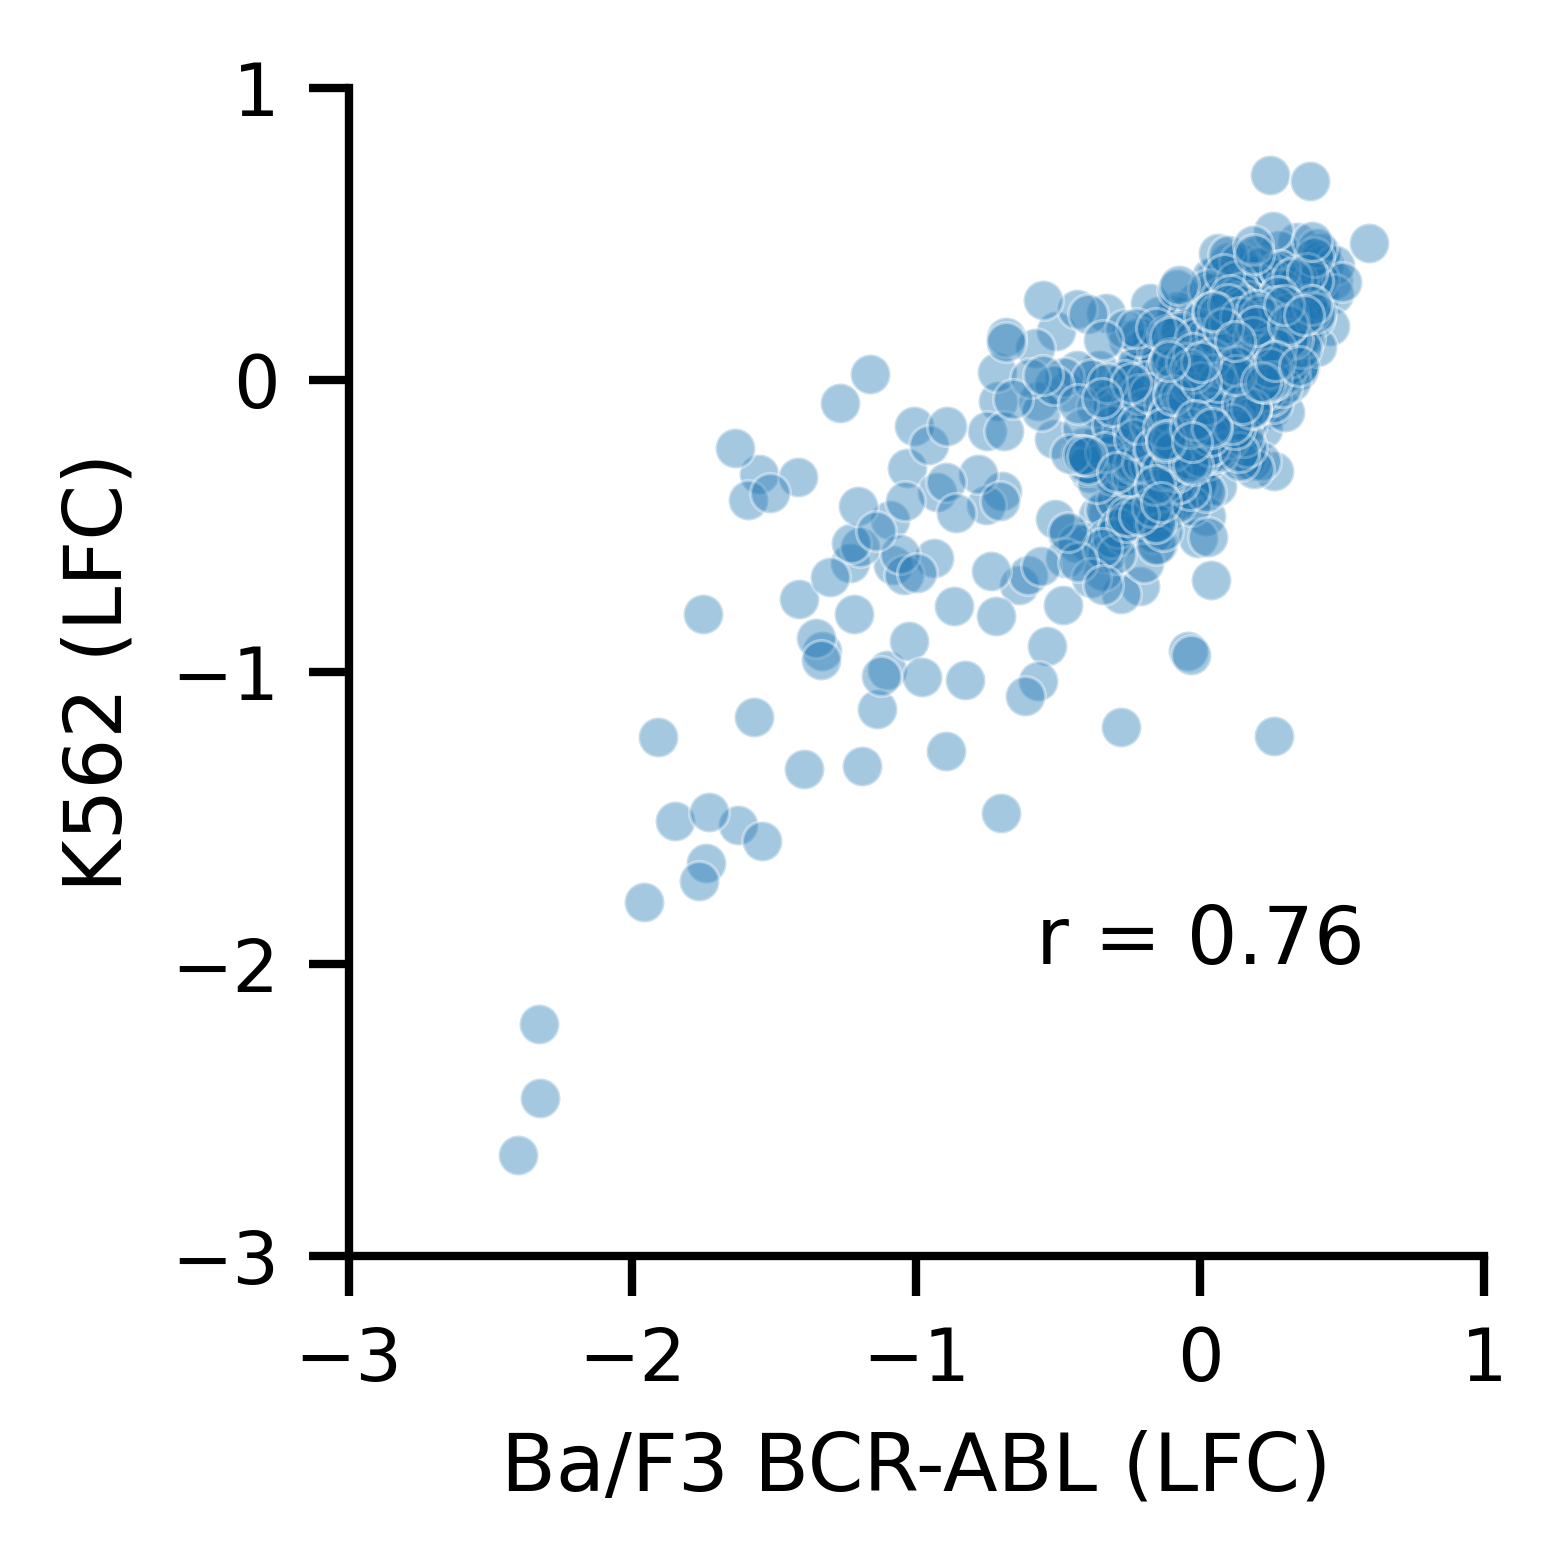

In [15]:
sns.reset_defaults()
%matplotlib inline

sns.set_context('paper')
plt.figure(figsize=(2.7,2.7), dpi=600)
comp = sns.scatterplot(x='log2FoldChange_BaF3', y='log2FoldChange_K562', alpha=0.4, data=Cell_comparison)
comp.set(xlabel='Ba/F3 BCR-ABL (LFC)', ylabel='K562 (LFC)', xticks=[1, 0, -1, -2, -3], yticks=[1, 0, -1, -2, -3], ylim=[-3, 1])
comp.text(0, -2, 'r = 0.76', horizontalalignment='center')
sns.despine()
plt.tight_layout()
comp.get_figure().savefig("ABE Screen Freq Cutoff 10000.svg" , transparent=True) 

In [16]:
Cell_comparison.set_index('sgName').corr()

,log2FoldChange_K562,log2FoldChange_BaF3
log2FoldChange_K562,1.000000,0.755872
log2FoldChange_BaF3,0.755872,1.000000
